### Data Preparation

Before training models, there are still a few things we should do. Let us import libraries, check imbalance in our dataset classes, resample, and shuffle data. 

---

### Importing libraries


In [1]:
# import our data
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.linear_model import LogisticRegression, Lasso, SGDClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier

---
### Loading data

In [2]:
# Load the data from the pickle file
with open("train_test_data.pkl", "rb") as f:
    X_train_, X_test_, y_train_, y_test_ = pickle.load(f)

# Check the shapes of the imported data
print("X_train_final shape:", X_train_.shape)
print("X_test_final shape:", X_test_.shape)
print("y_train_encoded shape:", y_train_.shape)
print("y_test shape:", y_test_.shape)


X_train_final shape: (91589, 838)
X_test_final shape: (10177, 838)
y_train_encoded shape: (91589,)
y_test shape: (10177,)


In [3]:
# Check class distribution
unique_classes, class_counts = np.unique(y_train_, return_counts=True)
class_distribution = dict(zip(unique_classes, class_counts))
class_distribution = {int(k): int(v) for k, v in class_distribution.items()}

print("Class Distribution in y_train_encoded:", class_distribution)

Class Distribution in y_train_encoded: {0: 10245, 1: 31989, 2: 49355}


As we can see, we need to oversample class 0 and 1. We do not use SMOTE or ASYN cause some dependency problems arise. 

In [4]:
# Define the dataset
X_train = X_train_.copy()
y_train = y_train_.copy()

print("Original class distribution:")
print(Counter({int(k): int(v) for k, v in Counter(y_train).items()}))

# Identify classes and their counts
classes, counts = np.unique(y_train, return_counts=True)
max_count = counts.max()

# Initialize placeholders for synthetic samples
X_synthetic = []
y_synthetic = []

# Oversample each minority class
k_neighbors = 5
for cls, count in zip(classes, counts):
    if count < max_count:
        n_samples_to_generate = max_count - count
        
        # Get minority class samples
        X_minority = X_train[y_train == cls]
        
        # Convert to numpy array if it's a DataFrame
        X_minority_values = X_minority.values if isinstance(X_minority, pd.DataFrame) else X_minority
        
        # Fit nearest neighbors
        nbrs = NearestNeighbors(n_neighbors=k_neighbors).fit(X_minority_values)
        indices = nbrs.kneighbors(X_minority_values, return_distance=False)

        # Generate synthetic samples
        synthetic_samples = []
        for _ in range(n_samples_to_generate):
            idx = np.random.randint(0, len(X_minority_values))
            nn_idx = indices[idx][np.random.randint(1, k_neighbors)]
            
            # Use numpy array indexing
            diff = X_minority_values[nn_idx] - X_minority_values[idx]
            synthetic_sample = X_minority_values[idx] + np.random.rand() * diff
            
            synthetic_samples.append(synthetic_sample)

        synthetic_samples = np.array(synthetic_samples)
        X_synthetic.append(synthetic_samples)
        y_synthetic.append(np.full(n_samples_to_generate, cls))

# Combine synthetic samples with original dataset
X_synthetic = np.vstack(X_synthetic) if X_synthetic else np.empty((0, X_train.shape[1]))
y_synthetic = np.hstack(y_synthetic) if y_synthetic else np.empty((0,))

# Convert X_train to numpy array
X_train_values = X_train.values if isinstance(X_train, pd.DataFrame) else X_train

# Combine original and synthetic samples
X_train_balanced = np.vstack([X_train_values, X_synthetic])
y_train_balanced = np.hstack([y_train, y_synthetic])

# Verify the new class distribution
print("\nBalanced class distribution:")
print(Counter({int(k): int(v) for k, v in Counter(y_train_balanced).items()}))

# Output shapes
print("\nBalanced dataset shapes:")
print(f"Features shape: {X_train_balanced.shape}")
print(f"Target shape: {y_train_balanced.shape}")

Original class distribution:
Counter({2: 49355, 1: 31989, 0: 10245})

Balanced class distribution:
Counter({1: 49355, 2: 49355, 0: 49355})

Balanced dataset shapes:
Features shape: (148065, 838)
Target shape: (148065,)


We have oversampled the data so that the data is balanced

In [5]:
# Shuffle up the data
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)

# Verify the shapes after shuffling
print("Shuffled dataset shapes:")
print(f"Features shape: {X_train_balanced.shape}")
print(f"Target shape: {y_train_balanced.shape}")


Shuffled dataset shapes:
Features shape: (148065, 838)
Target shape: (148065,)


--- 
### Creating validation set
We would first split our train data into validation and train set before we build our model

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_balanced, y_train_balanced, test_size=0.2, random_state=42
)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(118452, 838) (29613, 838) (118452,) (29613,)


---
### Building baseline models
**Listed below are our baseline models**

- Logistic Regression
- LightGBM
- K-Nearest Neighbours
- XGBoost
- Support Vector Machine
- Random Forest 
---
- We would first build the model and evaluate their performance on the training set by using different metrics
- If it performs well, we would further tune its hyperparameters
___

## 1. Logistic Regression
- We would first perform elastic net regularisation to further select the features

In [7]:
# First scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test_)
X_val_scaled = scaler.transform(X_val)

# Use elastic net for feature selection
elastic_net = LogisticRegression(
    penalty='elasticnet',
    solver='saga', 
    l1_ratio=0.5,   
    random_state=42
)
selector = SelectFromModel(elastic_net, max_features=100)  

# Fit and transform training data
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)
X_val_selected = selector.transform(X_val_scaled)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Model Performance:
Training Accuracy: 0.4913
Validation Accuracy: 0.4927
Accuracy Difference (Training - Validation): -0.0014
Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.51      0.46      0.48     39349
readmitted_>30       0.44      0.40      0.42     39584
 readmitted_NO       0.52      0.61      0.56     39519

      accuracy                           0.49    118452
     macro avg       0.49      0.49      0.49    118452
  weighted avg       0.49      0.49      0.49    118452



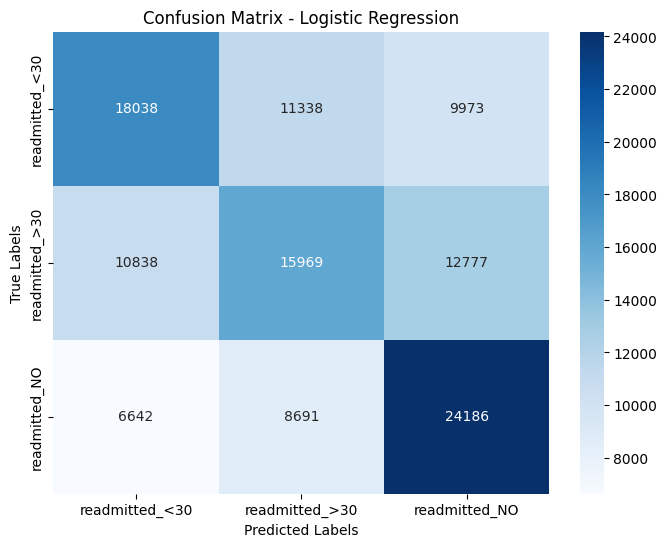

In [8]:
# Now apply regular logistic regression
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_selected, y_train)

# Make predictions
y_train_pred = logreg.predict(X_train_selected)
y_val_pred = logreg.predict(X_val_selected)

# Evaluate the model
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
accuracy_diff = train_accuracy - val_accuracy

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Accuracy Difference (Training - Validation): {accuracy_diff:.4f}")

# Classification Report
print("Classification Report:\n")
print(classification_report(y_train, y_train_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"], 
            yticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

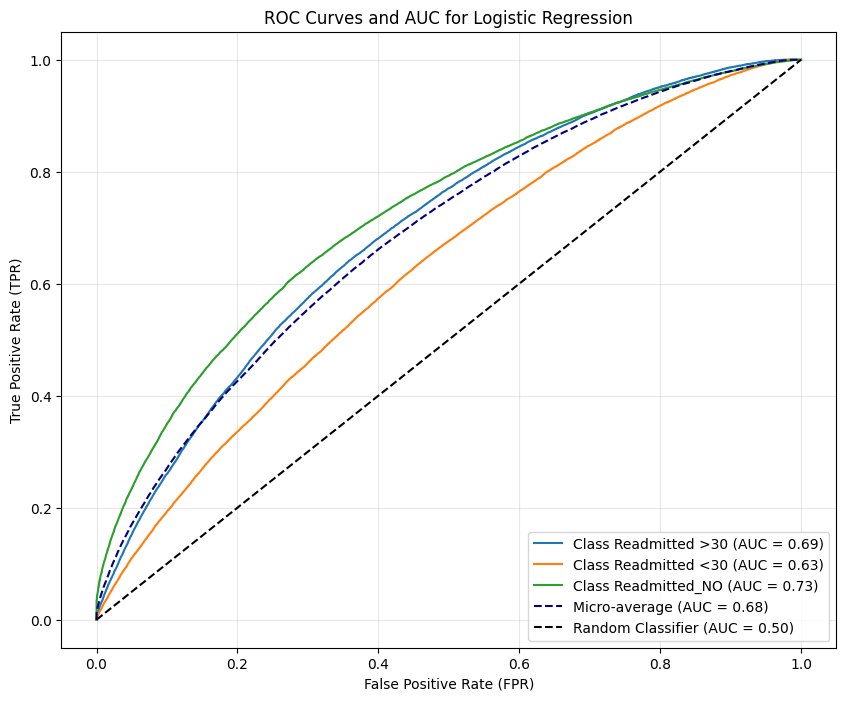

In [9]:
# Binarize the target labels (required for multi-class ROC)
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']

y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]
y_pred_proba = logreg.predict_proba(X_train_selected)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for Logistic Regression")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Although this model doesn't overfit, it doesn't have a great performance thus we wouldn't be tuning its hyperparameters to achieve a better accuracy

---

## 2. LightGBM


Model Performance:
Training Accuracy: 0.6399
Validation Accuracy: 0.6372
Accuracy Difference (Training - Validation): 0.0028
Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.71      0.74      0.72     39349
readmitted_>30       0.54      0.39      0.45     39584
 readmitted_NO       0.64      0.80      0.71     39519

      accuracy                           0.64    118452
     macro avg       0.63      0.64      0.63    118452
  weighted avg       0.63      0.64      0.63    118452



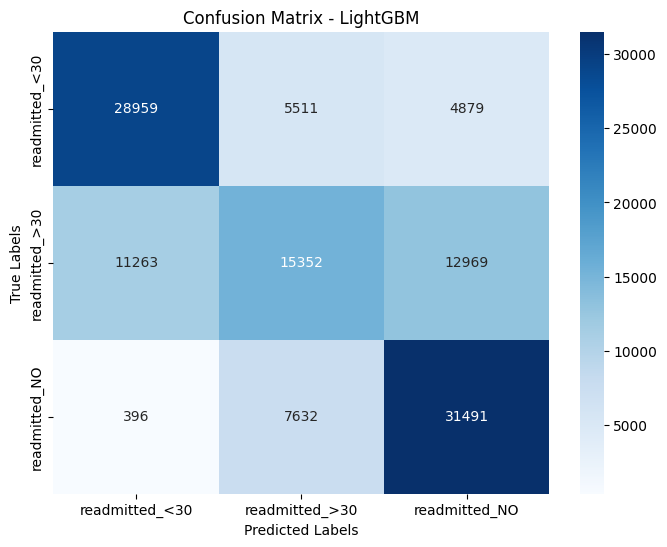

In [10]:
# Train the LightBGM model
lgbm_model = lgb.LGBMClassifier(
        objective='multiclass',
        num_class=len(np.unique(y_train)),
        random_state=42,
        n_estimators=100,
        max_depth=4,
        verbose=-1,
        n_jobs=-1
    )
lgbm_model.fit(X_train, y_train)

y_train_pred = lgbm_model.predict(X_train)
y_val_pred = lgbm_model.predict(X_val)

# Evaluate the model
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
accuracy_diff = train_accuracy - val_accuracy

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Accuracy Difference (Training - Validation): {accuracy_diff:.4f}")
# Classification Report
print("Classification Report:\n")
print(classification_report(y_train, y_train_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"], 
            yticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"])
plt.title("Confusion Matrix - LightGBM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

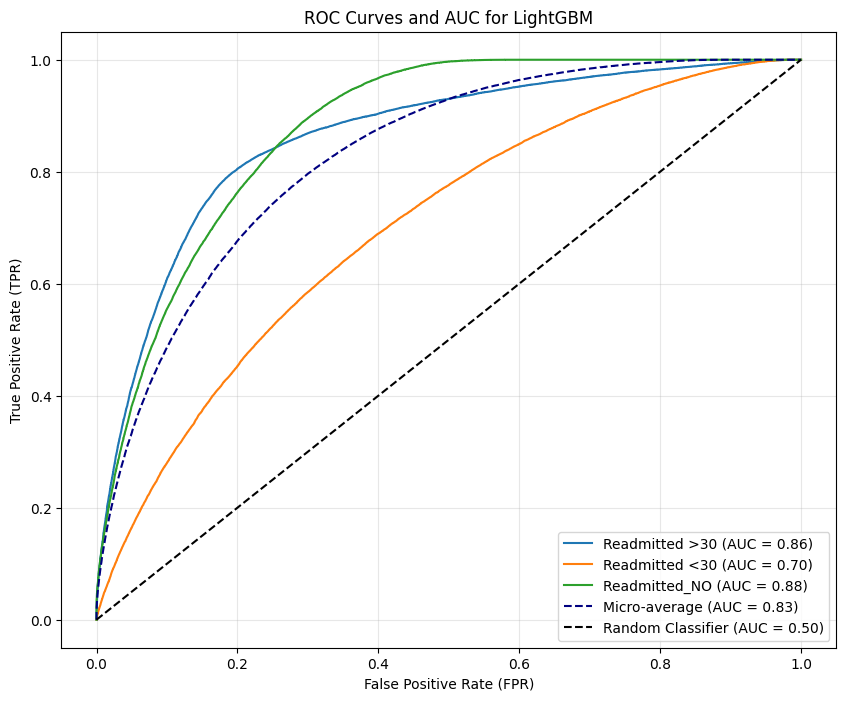

In [11]:
# Binarize the target labels
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Get probability predictions
y_pred_proba = lgbm_model.predict_proba(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for LightGBM")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

This model has no sign of overfitting and performs well, we will tune its hyperparameters to further enhance its performance.

---


Results for max_depth=4:
Mean Training Score: 0.640 (+/- 0.002)
Mean Validation Score: 0.632 (+/- 0.008)
Score difference: 0.008

Results for max_depth=6:
Mean Training Score: 0.659 (+/- 0.002)
Mean Validation Score: 0.643 (+/- 0.009)
Score difference: 0.017

Results for max_depth=8:
Mean Training Score: 0.666 (+/- 0.001)
Mean Validation Score: 0.646 (+/- 0.009)
Score difference: 0.020

Results for max_depth=10:
Mean Training Score: 0.668 (+/- 0.002)
Mean Validation Score: 0.649 (+/- 0.007)
Score difference: 0.020


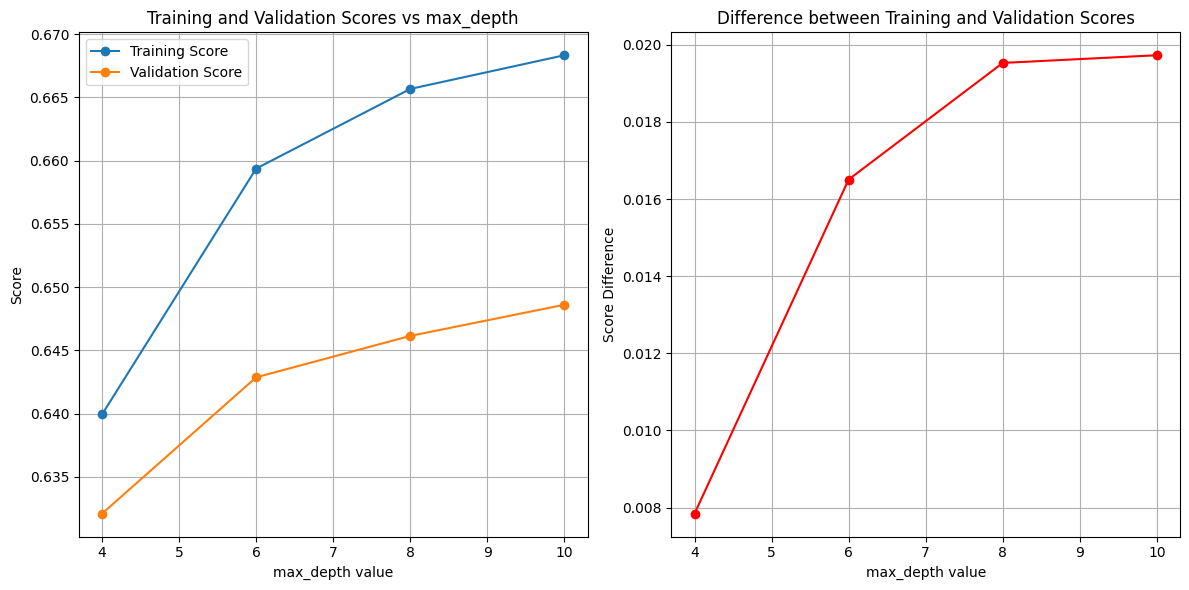

In [12]:
# Range of max_depth values to try
max_depth = [4, 6, 8, 10]
results = {}

for depth in max_depth:
    # Train LGBM model with different max_depth
    lgbm_model = lgb.LGBMClassifier(
        objective='multiclass',
        num_class=len(np.unique(y_train)),
        random_state=42,
        n_estimators=100,
        max_depth=depth,
        verbose=-1,
        n_jobs=-1
    )
    
    # Setup cross-validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    
    # Get both training and validation scores
    cv_results = cross_validate(lgbm_model, X_train, y_train, 
                             cv=kf, 
                             scoring='accuracy',
                             return_train_score=True)
    
    difference = cv_results['train_score'].mean() - cv_results['test_score'].mean()
    
    # Store results for this depth value
    results[depth] = {
        'train_score': cv_results['train_score'].mean(),
        'train_std': cv_results['train_score'].std() * 2,
        'test_score': cv_results['test_score'].mean(),
        'test_std': cv_results['test_score'].std() * 2,
        'difference': difference
    }
    
    # Print results for each depth
    print(f"\nResults for max_depth={depth}:")
    print(f"Mean Training Score: {cv_results['train_score'].mean():.3f} (+/- {cv_results['train_score'].std() * 2:.3f})")
    print(f"Mean Validation Score: {cv_results['test_score'].mean():.3f} (+/- {cv_results['test_score'].std() * 2:.3f})")
    print(f"Score difference: {difference:.3f}")

# Plot results
plt.figure(figsize=(12, 6))
train_scores = [results[d]['train_score'] for d in max_depth]
test_scores = [results[d]['test_score'] for d in max_depth]
differences = [results[d]['difference'] for d in max_depth]

# Plot training and validation scores
plt.subplot(1, 2, 1)
plt.plot(max_depth, train_scores, marker='o', label='Training Score')
plt.plot(max_depth, test_scores, marker='o', label='Validation Score')
plt.xlabel('max_depth value')
plt.ylabel('Score')
plt.title('Training and Validation Scores vs max_depth')
plt.legend()
plt.grid(True)

# Plot differences
plt.subplot(1, 2, 2)
plt.plot(max_depth, differences, marker='o', color='red')
plt.xlabel('max_depth value')
plt.ylabel('Score Difference')
plt.title('Difference between Training and Validation Scores')
plt.grid(True)

plt.tight_layout()
plt.show()

Since the difference between training and validation accuracy is small even when the depth is 10, we would evaluate the model again using this value.

---


Model Performance:
Training Accuracy: 0.6668
Validation Accuracy: 0.6522
Accuracy Difference (Training - Validation): 0.0146
Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.73      0.76      0.75     39349
readmitted_>30       0.58      0.43      0.50     39584
 readmitted_NO       0.66      0.81      0.73     39519

      accuracy                           0.67    118452
     macro avg       0.66      0.67      0.66    118452
  weighted avg       0.66      0.67      0.66    118452



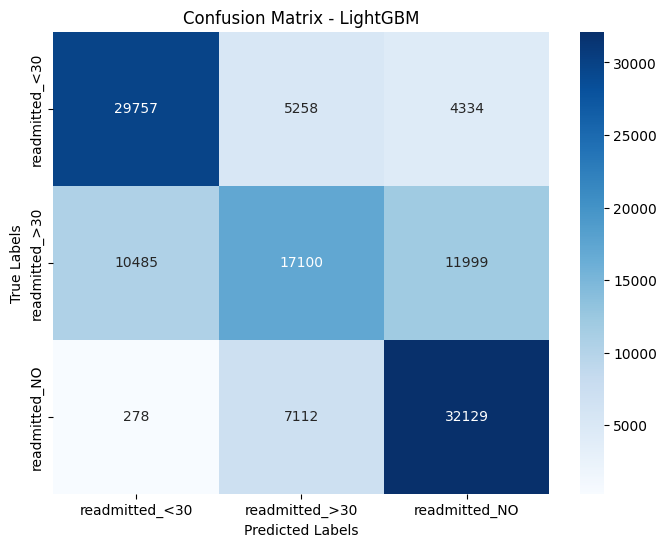

In [13]:
# Train the LightBGM model
lgbm_model = lgb.LGBMClassifier(
        objective='multiclass',
        num_class=len(np.unique(y_train)),
        random_state=42,
        n_estimators=100,
        max_depth=10,
        verbose=-1,
        n_jobs=-1
    )
lgbm_model.fit(X_train, y_train)

y_train_pred = lgbm_model.predict(X_train)
y_val_pred = lgbm_model.predict(X_val)

# Evaluate the model
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
accuracy_diff = train_accuracy - val_accuracy

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Accuracy Difference (Training - Validation): {accuracy_diff:.4f}")
# Classification Report
print("Classification Report:\n")
print(classification_report(y_train, y_train_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"], 
            yticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"])
plt.title("Confusion Matrix - LightGBM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

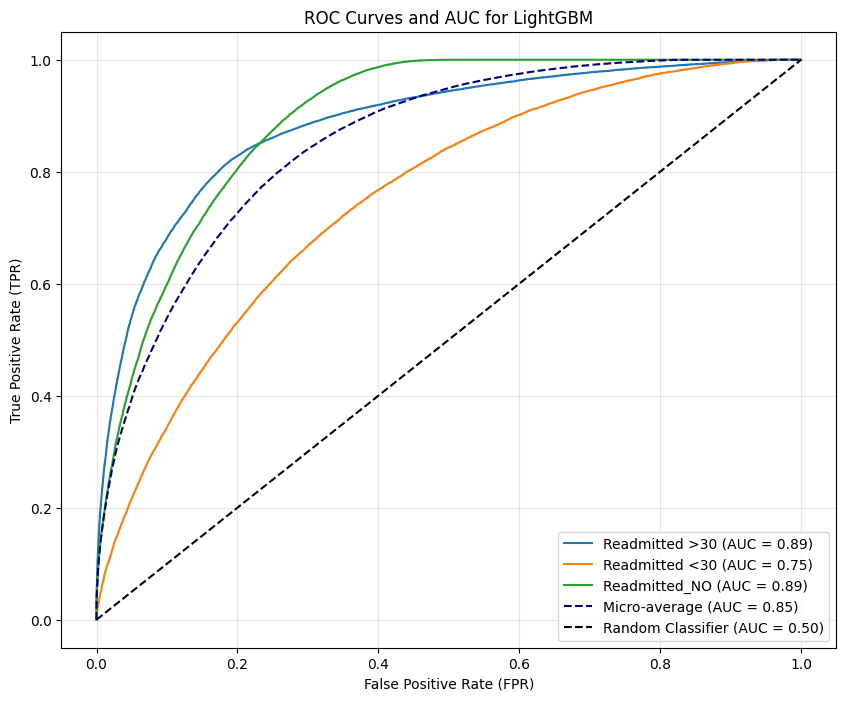

In [14]:
# Binarize the target labels
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Get probability predictions
y_pred_proba = lgbm_model.predict_proba(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for LightGBM")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

---
## 3. KNN Classifier



Model Performance:
Training Accuracy: 0.7142
Validation Accuracy: 0.6155
Accuracy Difference (Training - Validation): 0.0987
Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.68      0.99      0.80     39349
readmitted_>30       0.70      0.76      0.73     39584
 readmitted_NO       0.86      0.40      0.55     39519

      accuracy                           0.71    118452
     macro avg       0.75      0.71      0.69    118452
  weighted avg       0.75      0.71      0.69    118452



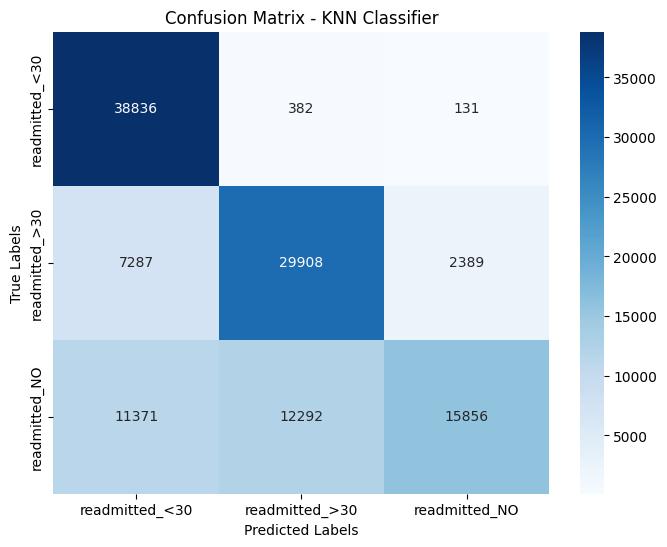

In [15]:
# Train KNN model
knn_model = KNeighborsClassifier(
    n_neighbors=5, 
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2, 
    metric='minkowski',
)
knn_model.fit(X_train, y_train)

# Make predictions
y_train_pred = knn_model.predict(X_train)
y_val_pred = knn_model.predict(X_val)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
accuracy_diff = train_accuracy - val_accuracy

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Accuracy Difference (Training - Validation): {accuracy_diff:.4f}")
# Print Classification Report
print("Classification Report:\n")
print(classification_report(y_train, y_train_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"],
            yticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"])
plt.title("Confusion Matrix - KNN Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

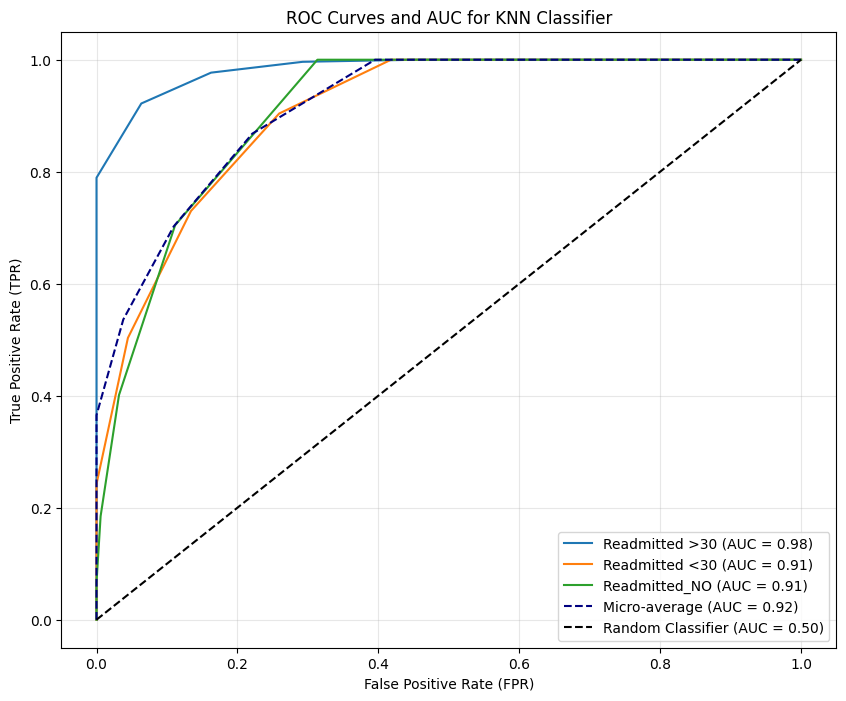

In [16]:
# Binarize the target labels
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Get probability predictions
y_pred_proba = knn_model.predict_proba(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for KNN Classifier")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

This models performs well on the training set, but slightly worse on the validation set, suggesting that overfitting might occur. Therefore, we are going to tune its hyperparameters to strike a balance between its performance and generalization.

---


Results for k=3:
Mean Training Score: 0.794 (+/- 0.001)
Mean Validation Score: 0.640 (+/- 0.011)
Score difference: 0.153

Results for k=4:
Mean Training Score: 0.718 (+/- 0.001)
Mean Validation Score: 0.611 (+/- 0.010)
Score difference: 0.107

Results for k=5:
Mean Training Score: 0.706 (+/- 0.001)
Mean Validation Score: 0.600 (+/- 0.011)
Score difference: 0.106

Results for k=6:
Mean Training Score: 0.669 (+/- 0.001)
Mean Validation Score: 0.580 (+/- 0.010)
Score difference: 0.089


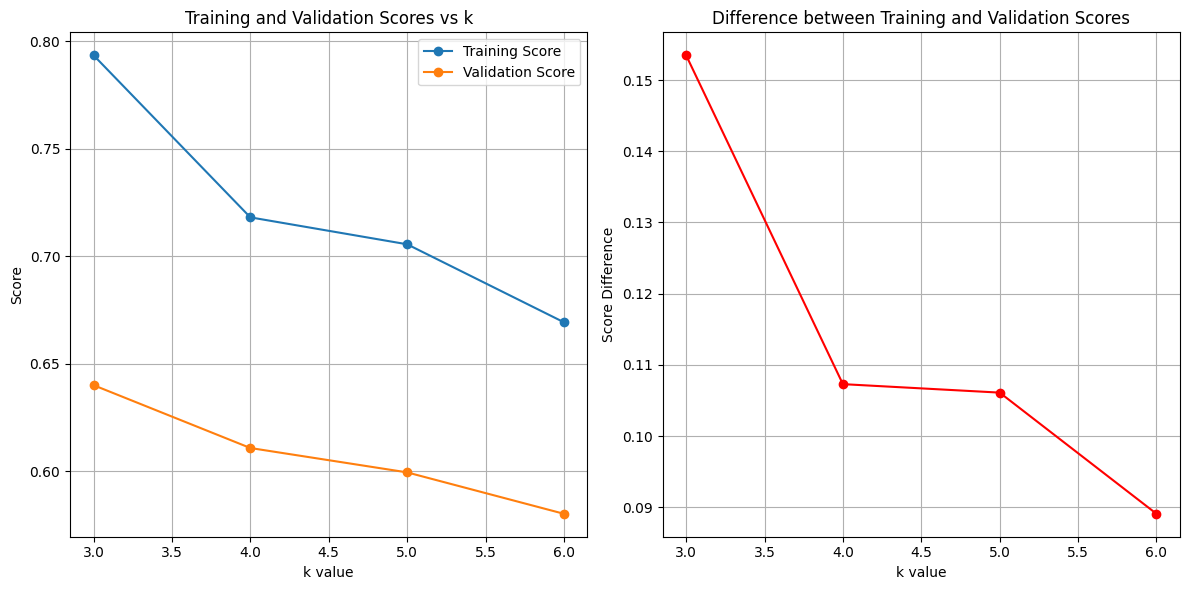

In [17]:
# Range of k values to try
k_values = [3, 4, 5, 6]  # You can modify this list
results = {}

for k in k_values:
    # Train KNN model with different k
    knn_model = KNeighborsClassifier(
        n_neighbors=k,
        weights='uniform',
        algorithm='auto',
        leaf_size=30,
        p=2,
        metric='minkowski',
    )
    
    # Setup cross-validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    
    # Get both training and validation scores
    cv_results = cross_validate(knn_model, X_train, y_train, 
                             cv=kf, 
                             scoring='accuracy',
                             return_train_score=True)
    
    difference = cv_results['train_score'].mean() - cv_results['test_score'].mean()
    
    # Store results for this k value
    results[k] = {
        'train_score': cv_results['train_score'].mean(),
        'train_std': cv_results['train_score'].std() * 2,
        'test_score': cv_results['test_score'].mean(),
        'test_std': cv_results['test_score'].std() * 2,
        'difference': difference
    }
    
    # Print results for each k
    print(f"\nResults for k={k}:")
    print(f"Mean Training Score: {cv_results['train_score'].mean():.3f} (+/- {cv_results['train_score'].std() * 2:.3f})")
    print(f"Mean Validation Score: {cv_results['test_score'].mean():.3f} (+/- {cv_results['test_score'].std() * 2:.3f})")
    print(f"Score difference: {difference:.3f}")

# Plot results
plt.figure(figsize=(12, 6))
train_scores = [results[k]['train_score'] for k in k_values]
test_scores = [results[k]['test_score'] for k in k_values]
differences = [results[k]['difference'] for k in k_values]

# Plot training and validation scores
plt.subplot(1, 2, 1)
plt.plot(k_values, train_scores, marker='o', label='Training Score')
plt.plot(k_values, test_scores, marker='o', label='Validation Score')
plt.xlabel('k value')
plt.ylabel('Score')
plt.title('Training and Validation Scores vs k')
plt.legend()
plt.grid(True)

# Plot differences
plt.subplot(1, 2, 2)
plt.plot(k_values, differences, marker='o', color='red')
plt.xlabel('k value')
plt.ylabel('Score Difference')
plt.title('Difference between Training and Validation Scores')
plt.grid(True)

plt.tight_layout()
plt.show()


After conducting k-fold cross validation, we would pick 4 as our k value as it could strike a better balance between accuracy and generalization. 

---
Therefore, we would evaluate the model again but using 4 as our k value.


Model Performance:
Training Accuracy: 0.7251
Validation Accuracy: 0.6257
Accuracy Difference (Training - Validation): 0.0994
Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.71      0.99      0.83     39349
readmitted_>30       0.68      0.80      0.74     39584
 readmitted_NO       0.90      0.38      0.53     39519

      accuracy                           0.73    118452
     macro avg       0.76      0.73      0.70    118452
  weighted avg       0.76      0.73      0.70    118452



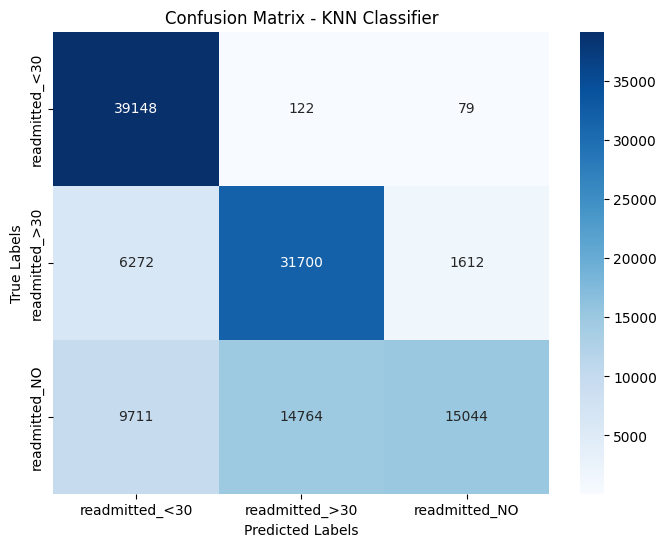

In [18]:
# Train KNN model
knn_model = KNeighborsClassifier(
    n_neighbors=4,  
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,  
    metric='minkowski',
)
knn_model.fit(X_train, y_train)

# Make predictions
y_train_pred = knn_model.predict(X_train)
y_val_pred = knn_model.predict(X_val)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
accuracy_diff = train_accuracy - val_accuracy

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Accuracy Difference (Training - Validation): {accuracy_diff:.4f}")
# Print Classification Report
print("Classification Report:\n")
print(classification_report(y_train, y_train_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"],
            yticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"])
plt.title("Confusion Matrix - KNN Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

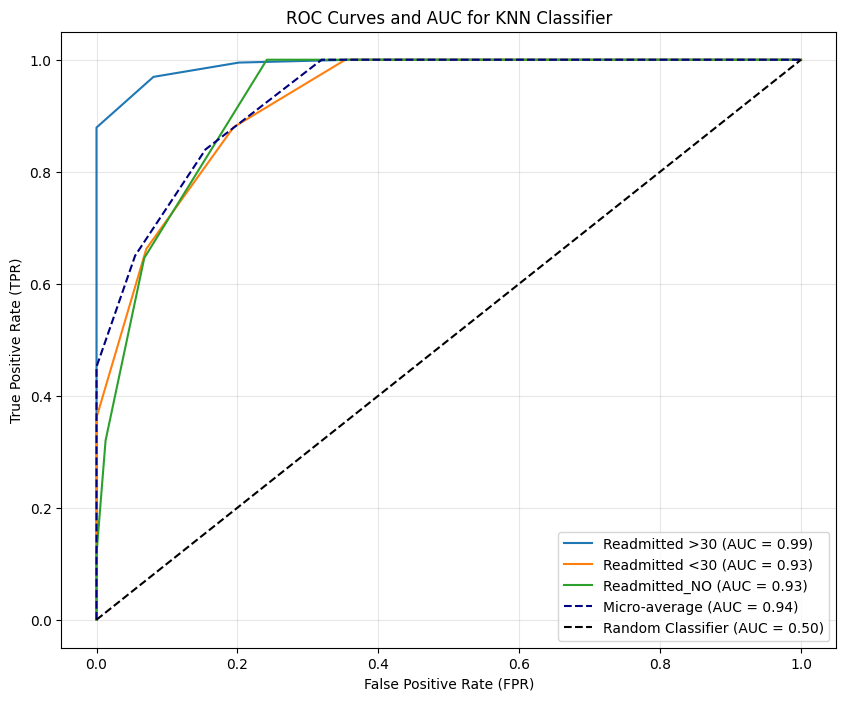

In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the target labels
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Get probability predictions
y_pred_proba = knn_model.predict_proba(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for KNN Classifier")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

---
## 4. XGBoost


Model Performance:
Training Accuracy: 0.7831
Validation Accuracy: 0.6767
Accuracy Difference (Training - Validation): 0.1064
Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.85      0.82      0.84     39349
readmitted_>30       0.76      0.65      0.70     39584
 readmitted_NO       0.75      0.87      0.81     39519

      accuracy                           0.78    118452
     macro avg       0.78      0.78      0.78    118452
  weighted avg       0.78      0.78      0.78    118452



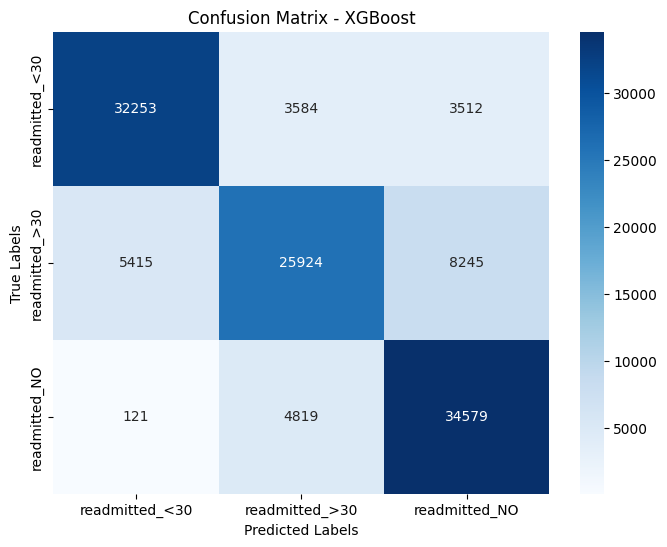

In [20]:
# Train XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',  
    num_class=3,              
    eval_metric='mlogloss',     
    random_state=42,
    max_depth=10,
)
xgb_model.fit(X_train, y_train)

# Make predictions
y_train_pred = xgb_model.predict(X_train)
y_val_pred = xgb_model.predict(X_val)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
accuracy_diff = train_accuracy - val_accuracy

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Accuracy Difference (Training - Validation): {accuracy_diff:.4f}")
# Print Classification Report
print("Classification Report:\n")
print(classification_report(y_train, y_train_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"],
            yticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

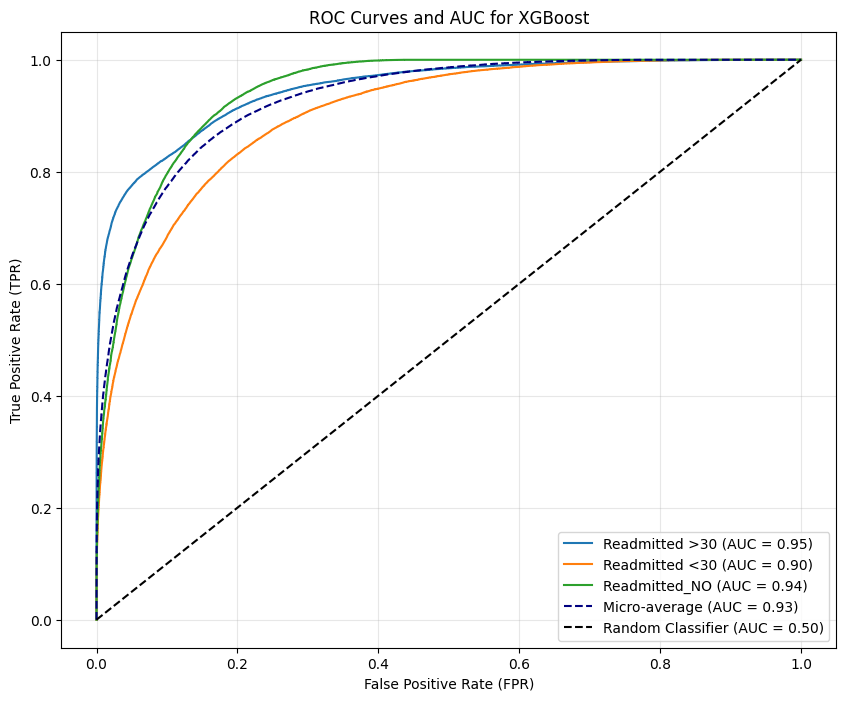

In [21]:
# Binarize the target labels
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Get probability predictions
y_pred_proba = xgb_model.predict_proba(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for XGBoost")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

We could tell the XGBoost model performs very well on the training set, yet the overfitting problem is quite serious for this model, so we would try tuning the hyperarameters to lower the difference between training and validation accuracies while maintaining its quality performance.

---


Results for depth=5:
Mean Training Score: 0.675 (+/- 0.001)
Mean Validation Score: 0.649 (+/- 0.008)
Score difference: 0.026

Results for depth=8:
Mean Training Score: 0.737 (+/- 0.004)
Mean Validation Score: 0.663 (+/- 0.007)
Score difference: 0.074

Results for depth=10:
Mean Training Score: 0.789 (+/- 0.005)
Mean Validation Score: 0.671 (+/- 0.008)
Score difference: 0.118

Results for depth=12:
Mean Training Score: 0.846 (+/- 0.004)
Mean Validation Score: 0.680 (+/- 0.009)
Score difference: 0.166


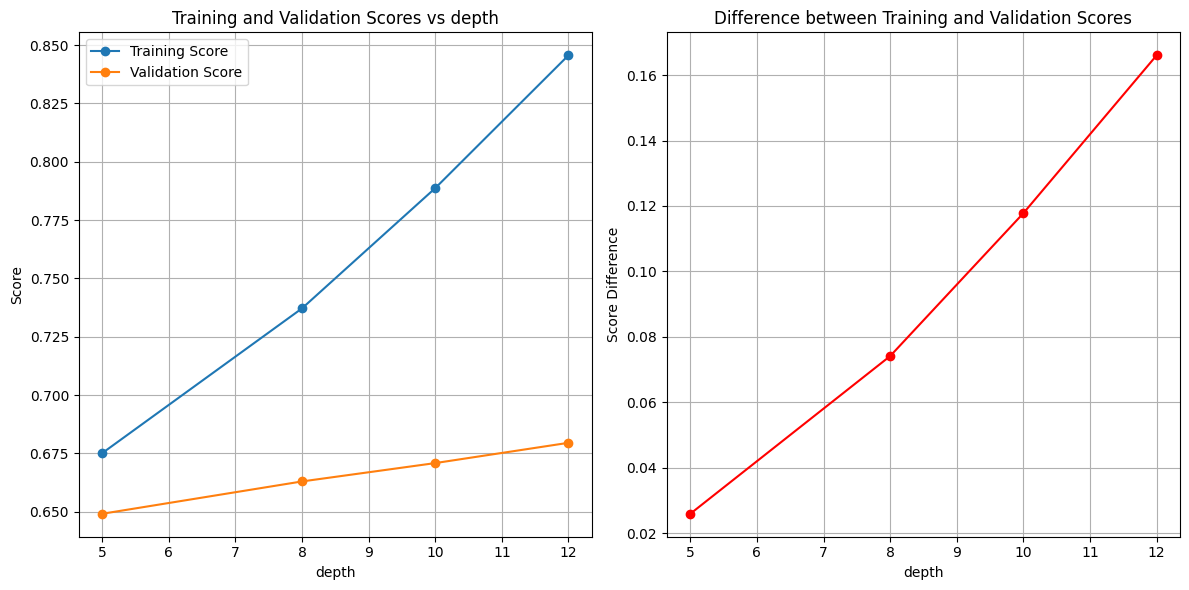

In [22]:
# Range of k values to try
max_depth = [5, 8, 10, 12]  # You can modify this list
results = {}

for depth in max_depth:
    # Train XGBoost model with different depths
    xgb_model = xgb.XGBClassifier(
        objective='multi:softprob',  
        num_class=3,              
        eval_metric='mlogloss',     
        random_state=42,
        max_depth=depth
    )
    
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    
    cv_results = cross_validate(xgb_model, X_train, y_train, 
                             cv=kf, 
                             scoring='accuracy',
                             return_train_score=True)
    
    difference = cv_results['train_score'].mean() - cv_results['test_score'].mean()
    
    # Store results for this depth value
    results[depth] = {
        'train_score': cv_results['train_score'].mean(),
        'train_std': cv_results['train_score'].std() * 2,
        'test_score': cv_results['test_score'].mean(),
        'test_std': cv_results['test_score'].std() * 2,
        'difference': difference
    }
    
    # Print results for each depth
    print(f"\nResults for depth={depth}:")
    print(f"Mean Training Score: {cv_results['train_score'].mean():.3f} (+/- {cv_results['train_score'].std() * 2:.3f})")
    print(f"Mean Validation Score: {cv_results['test_score'].mean():.3f} (+/- {cv_results['test_score'].std() * 2:.3f})")
    print(f"Score difference: {difference:.3f}")

# Plot results
plt.figure(figsize=(12, 6))
train_scores = [results[depth]['train_score'] for depth in max_depth]
test_scores = [results[depth]['test_score'] for depth in max_depth]
differences = [results[depth]['difference'] for depth in max_depth]

# Plot training and validation scores
plt.subplot(1, 2, 1)
plt.plot(max_depth, train_scores, marker='o', label='Training Score')
plt.plot(max_depth, test_scores, marker='o', label='Validation Score')
plt.xlabel('depth')
plt.ylabel('Score')
plt.title('Training and Validation Scores vs depth')
plt.legend()
plt.grid(True)

# Plot differences
plt.subplot(1, 2, 2)
plt.plot(max_depth, differences, marker='o', color='red')
plt.xlabel('depth')
plt.ylabel('Score Difference')
plt.title('Difference between Training and Validation Scores')
plt.grid(True)

plt.tight_layout()
plt.show()


After tuning its hyperparameter and referring to the graph, we would choose 9 as the depth as it reduces the overfitting problem while maintaining an acceptable performance

---
Therefore, we would evaluate the model again using the new hyperparameter


Model Performance:
Training Accuracy: 0.7575
Validation Accuracy: 0.6714
Accuracy Difference (Training - Validation): 0.0861
Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.83      0.81      0.82     39349
readmitted_>30       0.72      0.60      0.66     39584
 readmitted_NO       0.73      0.86      0.79     39519

      accuracy                           0.76    118452
     macro avg       0.76      0.76      0.75    118452
  weighted avg       0.76      0.76      0.75    118452



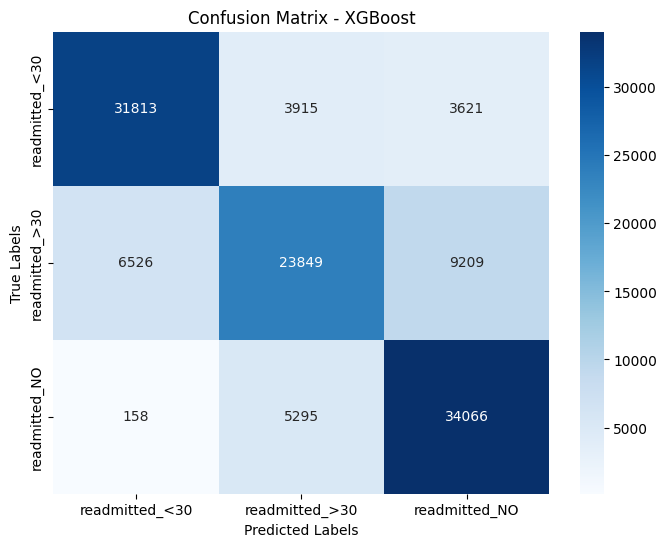

In [23]:
# Train XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',  
    num_class=3,              
    eval_metric='mlogloss',     
    random_state=42,
    max_depth=9,
)
xgb_model.fit(X_train, y_train)

# Make predictions
y_train_pred = xgb_model.predict(X_train)
y_val_pred = xgb_model.predict(X_val)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
accuracy_diff = train_accuracy - val_accuracy

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Accuracy Difference (Training - Validation): {accuracy_diff:.4f}")
# Print Classification Report
print("Classification Report:\n")
print(classification_report(y_train, y_train_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"],
            yticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

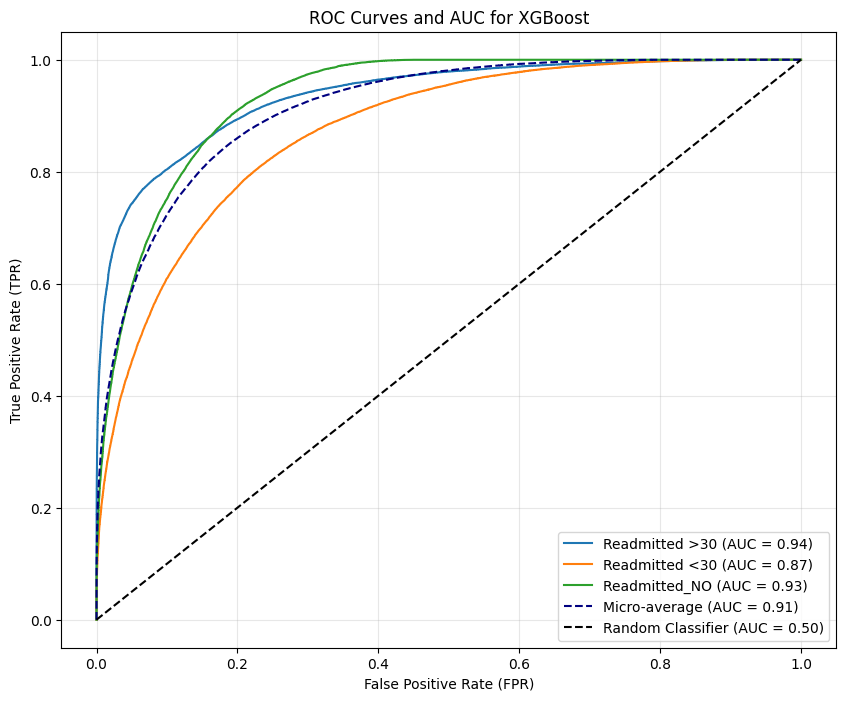

In [24]:
# Binarize the target labels
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Get probability predictions
y_pred_proba = xgb_model.predict_proba(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for XGBoost")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

---
## 5. Support Vector Machine


Model Performance:
Training Accuracy: 0.4865
Validation Accuracy: 0.4871
Accuracy Difference (Training - Validation): -0.0007
Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.48      0.66      0.56     39349
readmitted_>30       0.57      0.07      0.13     39584
 readmitted_NO       0.48      0.74      0.58     39519

      accuracy                           0.49    118452
     macro avg       0.51      0.49      0.42    118452
  weighted avg       0.51      0.49      0.42    118452



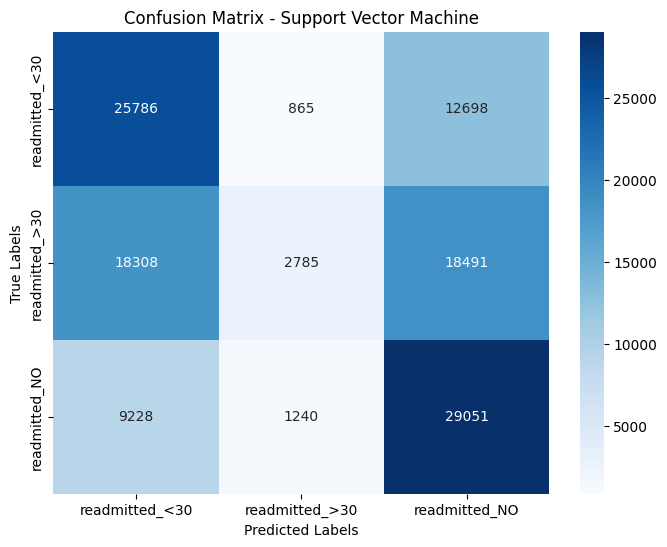

In [25]:
# Train SVM model
svm_model = SGDClassifier(
    loss='hinge',
    random_state=42,
    max_iter=1000,
    tol=0.0001,
    n_jobs=-1,  
)
svm_model.fit(X_train, y_train)

# Make predictions
y_train_pred = svm_model.predict(X_train)
y_val_pred = svm_model.predict(X_val)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
accuracy_diff = train_accuracy - val_accuracy

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Accuracy Difference (Training - Validation): {accuracy_diff:.4f}")
# Print Classification Report
print("Classification Report:\n")
print(classification_report(y_train, y_train_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"],
            yticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"])
plt.title("Confusion Matrix - Support Vector Machine")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

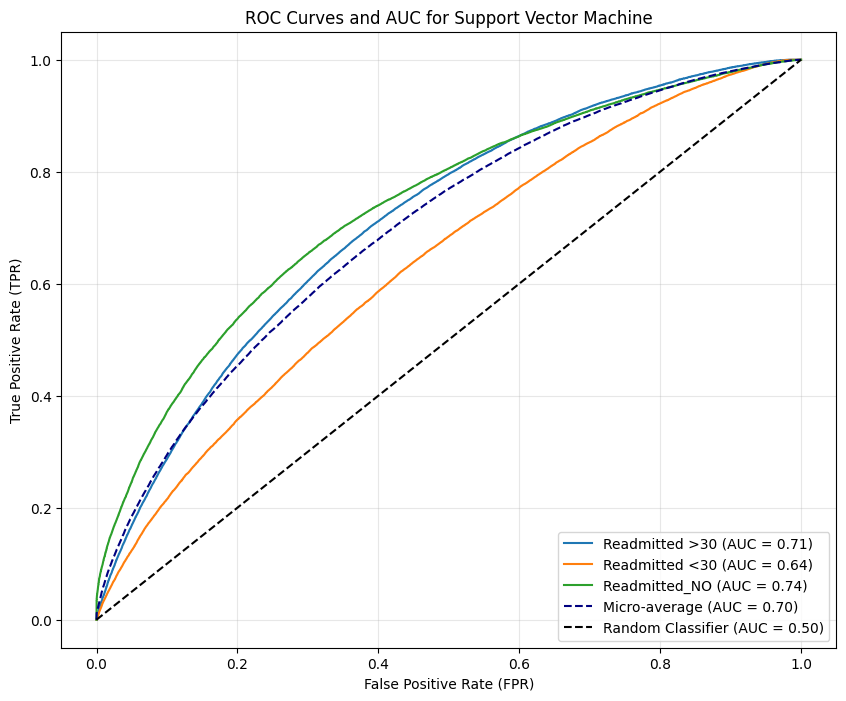

In [26]:
# Binarize the target labels
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Calibrate the model so that we could get probability predictions
calibrated_svm = CalibratedClassifierCV(svm_model, cv=5)
calibrated_svm.fit(X_train, y_train)

# Get probability predictions
y_pred_proba = calibrated_svm.predict_proba(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for Support Vector Machine")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

We could conclude that this model has no overfitting problem, yet it has the worst performance by far, therefore we wouldn't be tuning its hyperparameters to improve its accuracy and would proceed to the next model

---
## 6. Random Forest


Model Performance:
Training Accuracy: 0.7666
Validation Accuracy: 0.6488
Accuracy Difference (Training - Validation): 0.1179
Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.79      0.86      0.82     39349
readmitted_>30       0.82      0.59      0.68     39584
 readmitted_NO       0.72      0.86      0.78     39519

      accuracy                           0.77    118452
     macro avg       0.77      0.77      0.76    118452
  weighted avg       0.77      0.77      0.76    118452



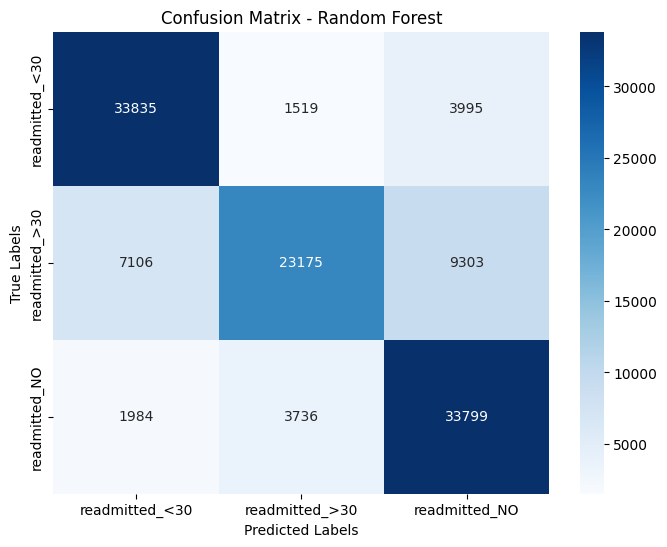

In [27]:
# Train Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=80,  
    random_state=42,     
    max_depth=20,      
    class_weight="balanced"  
)
rf_model.fit(X_train, y_train)

# Make predictions
y_train_pred = rf_model.predict(X_train)
y_val_pred = rf_model.predict(X_val)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
accuracy_diff = train_accuracy - val_accuracy

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Accuracy Difference (Training - Validation): {accuracy_diff:.4f}")
# Print Classification Report
print("Classification Report:\n")
print(classification_report(y_train, y_train_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"],
            yticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

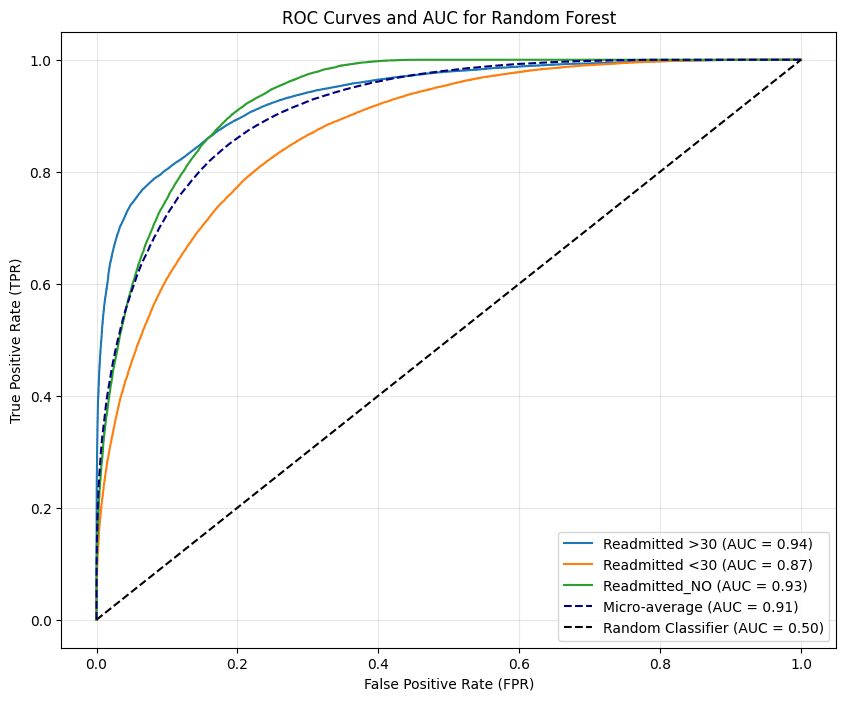

In [28]:
# Binarize the target labels
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Get probability predictions
y_pred_proba = xgb_model.predict_proba(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for Random Forest")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

This model is by far the best one regarding accuracy, yet it has the most serious overfitting problem, therefore we would have to tune its hyperparameters to lessen the overfitting issue

---


Results for depth=15:
Mean Training Score: 0.675 (+/- 0.009)
Mean Validation Score: 0.611 (+/- 0.010)
Score difference: 0.064

Results for depth=20:
Mean Training Score: 0.774 (+/- 0.006)
Mean Validation Score: 0.643 (+/- 0.009)
Score difference: 0.131

Results for depth=25:
Mean Training Score: 0.868 (+/- 0.006)
Mean Validation Score: 0.671 (+/- 0.007)
Score difference: 0.197

Results for depth=30:
Mean Training Score: 0.936 (+/- 0.005)
Mean Validation Score: 0.693 (+/- 0.005)
Score difference: 0.243


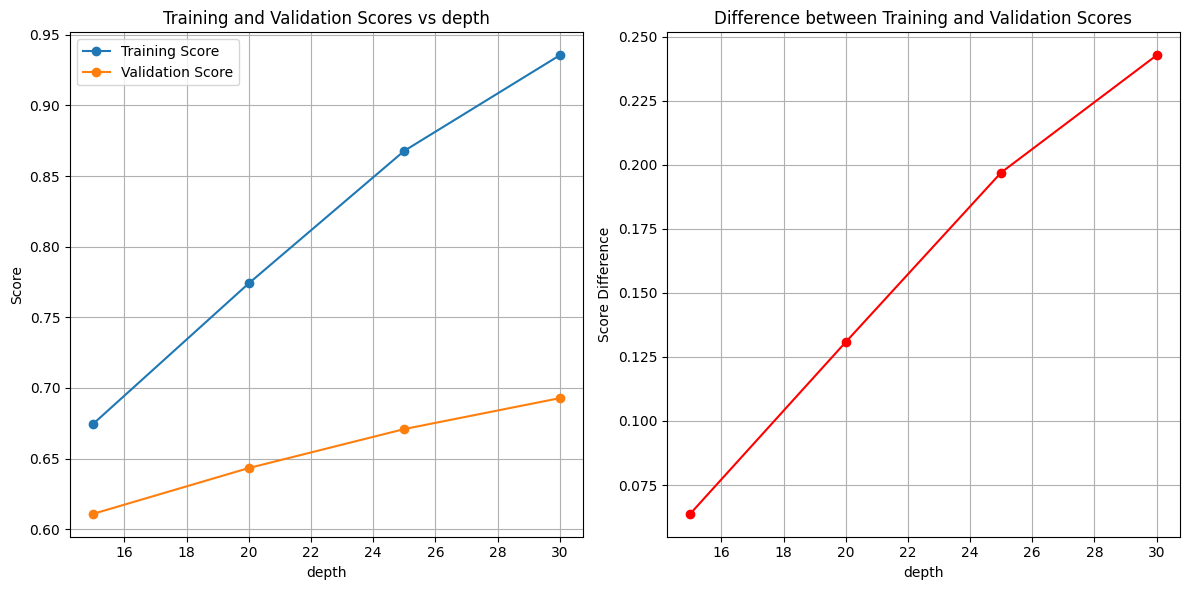

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_validate
import matplotlib.pyplot as plt
import numpy as np

# Range of k values to try
max_depth = [15, 20, 25, 30]  # You can modify this list
results = {}

for depth in max_depth:
    # Train random forest model with different depths
    rf_model = RandomForestClassifier(
        n_estimators=80,  
        random_state=42,     
        max_depth=depth,      
        class_weight="balanced"  
    )
    
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    
    cv_results = cross_validate(rf_model, X_train, y_train, 
                             cv=kf, 
                             scoring='accuracy',
                             return_train_score=True)
    
    difference = cv_results['train_score'].mean() - cv_results['test_score'].mean()
    
    # Store results for this depth value
    results[depth] = {
        'train_score': cv_results['train_score'].mean(),
        'train_std': cv_results['train_score'].std() * 2,
        'test_score': cv_results['test_score'].mean(),
        'test_std': cv_results['test_score'].std() * 2,
        'difference': difference
    }
    
    # Print results for each depth
    print(f"\nResults for depth={depth}:")
    print(f"Mean Training Score: {cv_results['train_score'].mean():.3f} (+/- {cv_results['train_score'].std() * 2:.3f})")
    print(f"Mean Validation Score: {cv_results['test_score'].mean():.3f} (+/- {cv_results['test_score'].std() * 2:.3f})")
    print(f"Score difference: {difference:.3f}")

# Plot results
plt.figure(figsize=(12, 6))
train_scores = [results[depth]['train_score'] for depth in max_depth]
test_scores = [results[depth]['test_score'] for depth in max_depth]
differences = [results[depth]['difference'] for depth in max_depth]

# Plot training and validation scores
plt.subplot(1, 2, 1)
plt.plot(max_depth, train_scores, marker='o', label='Training Score')
plt.plot(max_depth, test_scores, marker='o', label='Validation Score')
plt.xlabel('depth')
plt.ylabel('Score')
plt.title('Training and Validation Scores vs depth')
plt.legend()
plt.grid(True)

# Plot differences
plt.subplot(1, 2, 2)
plt.plot(max_depth, differences, marker='o', color='red')
plt.xlabel('depth')
plt.ylabel('Score Difference')
plt.title('Difference between Training and Validation Scores')
plt.grid(True)

plt.tight_layout()
plt.show() 


To achieve a balance between regularisation and accuracy and by referring to the graph, we would choose 18 as its max depth

---
We would evaluate the model again using 18 as the max depth


Model Performance:
Training Accuracy: 0.7255
Validation Accuracy: 0.6347
Accuracy Difference (Training - Validation): 0.0908
Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.75      0.83      0.79     39349
readmitted_>30       0.77      0.51      0.61     39584
 readmitted_NO       0.68      0.84      0.75     39519

      accuracy                           0.73    118452
     macro avg       0.73      0.73      0.72    118452
  weighted avg       0.73      0.73      0.72    118452



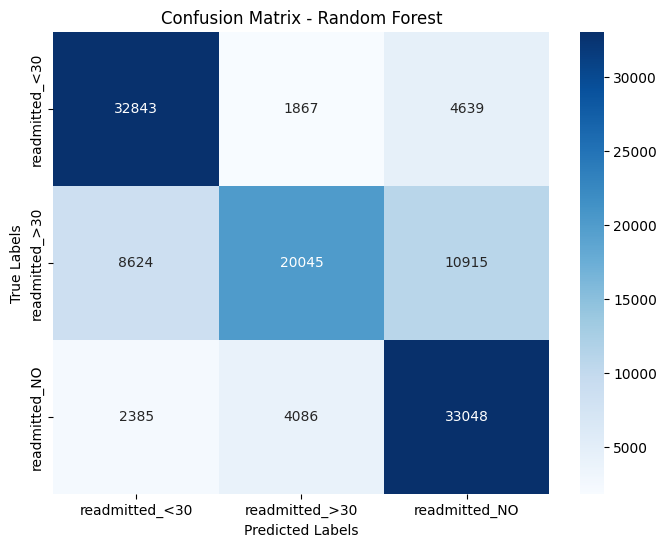

In [30]:
# Train Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=80,  
    random_state=42,     
    max_depth=18,      
    class_weight="balanced"  
)
rf_model.fit(X_train, y_train)

# Make predictions
y_train_pred = rf_model.predict(X_train)
y_val_pred = rf_model.predict(X_val)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
accuracy_diff = train_accuracy - val_accuracy

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Accuracy Difference (Training - Validation): {accuracy_diff:.4f}")
# Print Classification Report
print("Classification Report:\n")
print(classification_report(y_train, y_train_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"],
            yticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

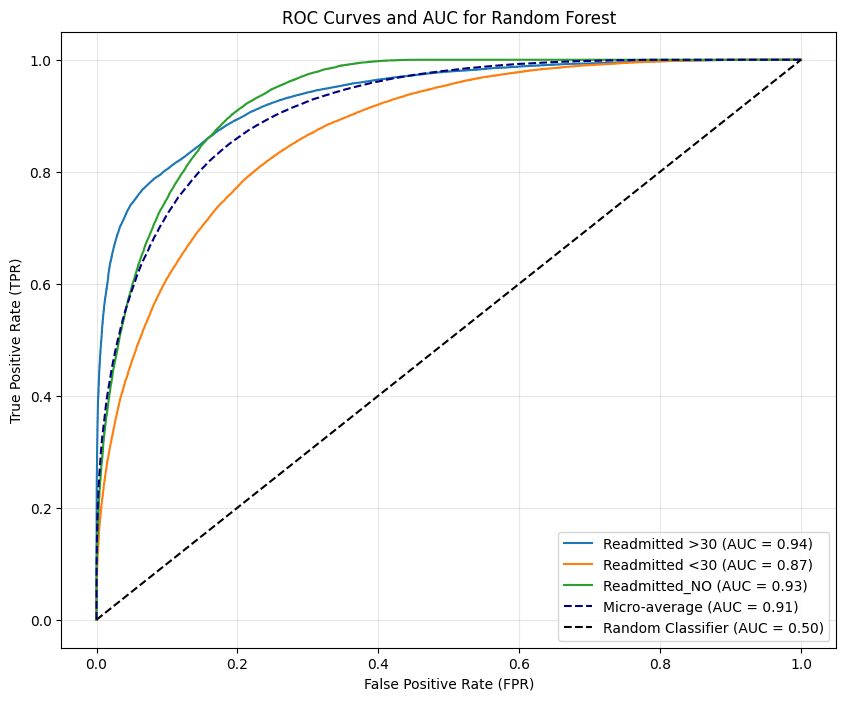

In [31]:
# Binarize the target labels
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Get probability predictions
y_pred_proba = xgb_model.predict_proba(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for Random Forest")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

---
### Evaluation of models using test set
- After tuning the hyperparameters for some of the models, we would evaluate their performance on the test set
---

## 1. Logistic regression

Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.19      0.40      0.26      1112
readmitted_>30       0.47      0.40      0.43      3556
 readmitted_NO       0.69      0.61      0.64      5509

      accuracy                           0.51     10177
     macro avg       0.45      0.47      0.44     10177
  weighted avg       0.56      0.51      0.53     10177



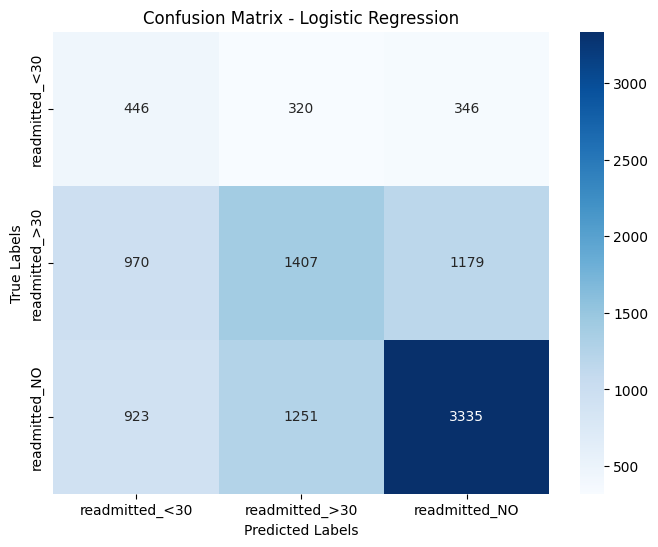

In [44]:
# Make predictions
y_pred = logreg.predict(X_test_selected)

print("Classification Report:\n")
print(classification_report(y_test_, y_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"], yticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

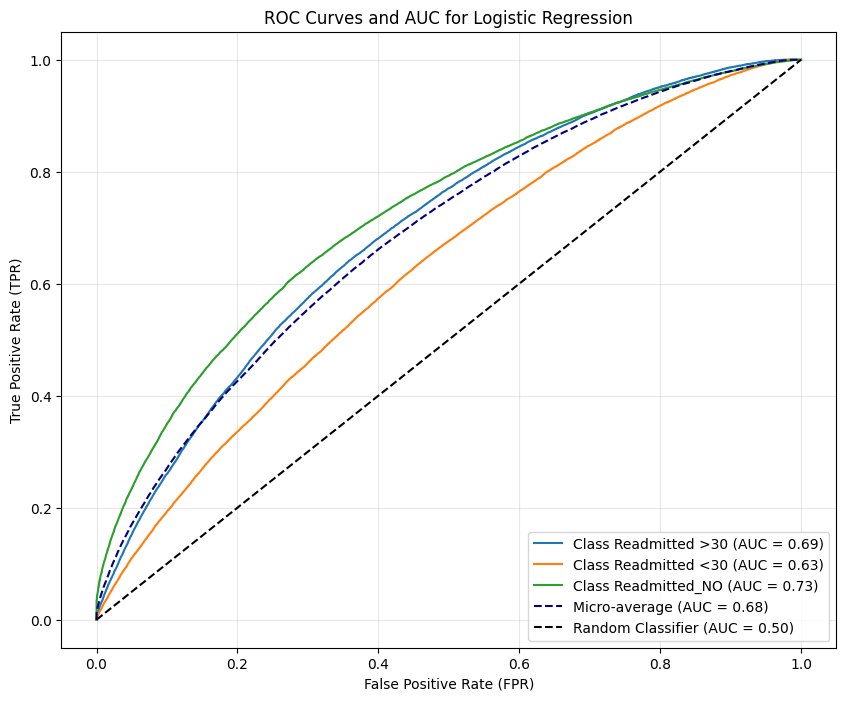

In [45]:
# Binarize the target labels (required for multi-class ROC)
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']

y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]
y_pred_proba = logreg.predict_proba(X_train_selected)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for Logistic Regression")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

---
## 2. LightGBM

Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.41      0.08      0.13      1112
readmitted_>30       0.53      0.50      0.52      3556
 readmitted_NO       0.66      0.79      0.72      5509

      accuracy                           0.61     10177
     macro avg       0.54      0.46      0.46     10177
  weighted avg       0.59      0.61      0.59     10177



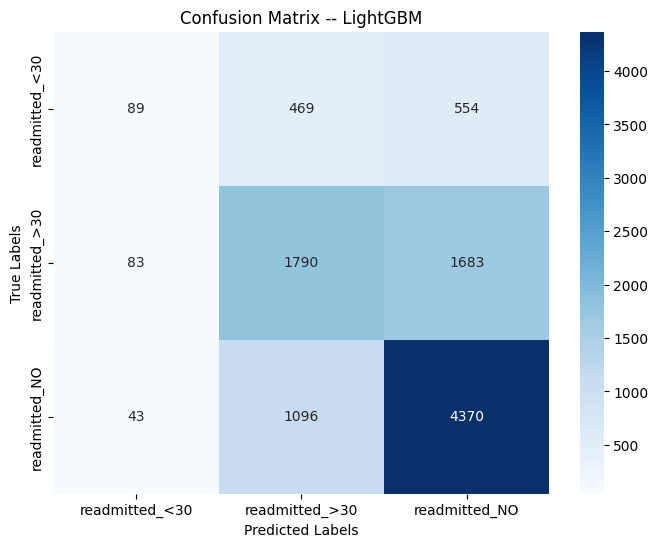

In [46]:
# Make predictions
y_pred = lgbm_model.predict(X_test_)

print("Classification Report:\n")
print(classification_report(y_test_, y_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"], yticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"])
plt.title("Confusion Matrix -- LightGBM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

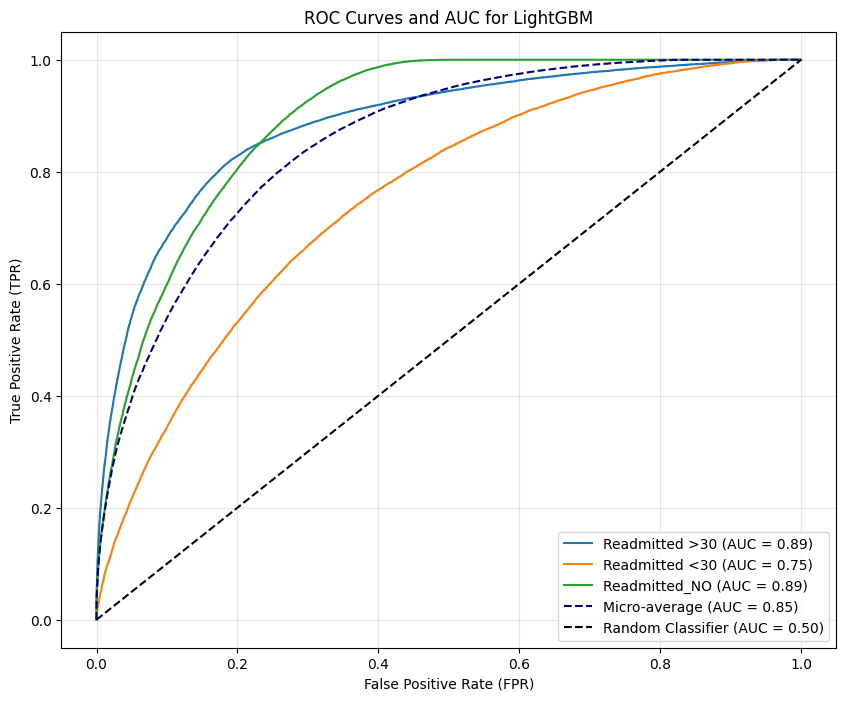

In [47]:
# Binarize the target labels
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Get probability predictions
y_pred_proba = lgbm_model.predict_proba(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for LightGBM")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

--- 
## 3. KNN classifier

Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.13      0.41      0.19      1112
readmitted_>30       0.37      0.48      0.42      3556
 readmitted_NO       0.63      0.22      0.33      5509

      accuracy                           0.33     10177
     macro avg       0.38      0.37      0.31     10177
  weighted avg       0.48      0.33      0.35     10177



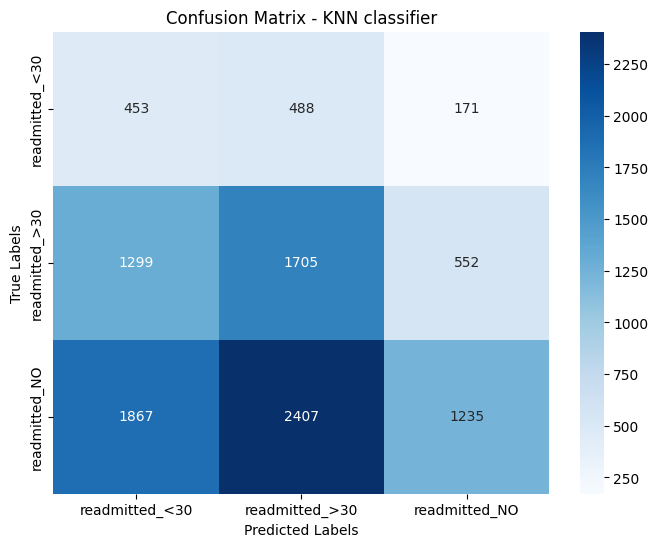

In [48]:
# Make predictions
y_pred = knn_model.predict(X_test_)

print("Classification Report:\n")
print(classification_report(y_test_, y_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"], yticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"])
plt.title("Confusion Matrix - KNN classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

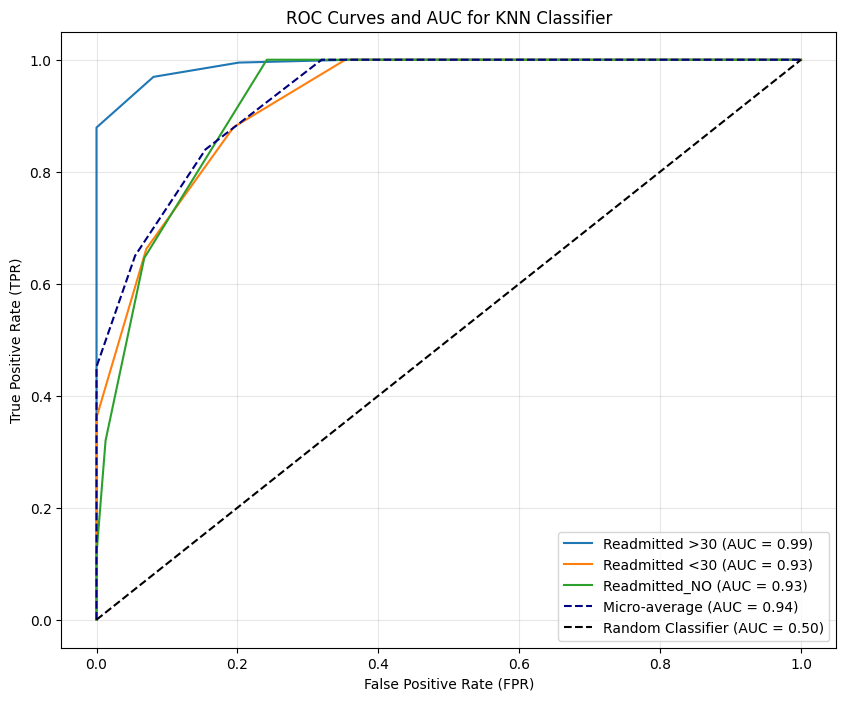

In [49]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the target labels
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Get probability predictions
y_pred_proba = knn_model.predict_proba(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for KNN Classifier")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

---
## 4. XGBoost

Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.40      0.08      0.13      1112
readmitted_>30       0.52      0.50      0.51      3556
 readmitted_NO       0.66      0.78      0.71      5509

      accuracy                           0.61     10177
     macro avg       0.53      0.45      0.45     10177
  weighted avg       0.58      0.61      0.58     10177



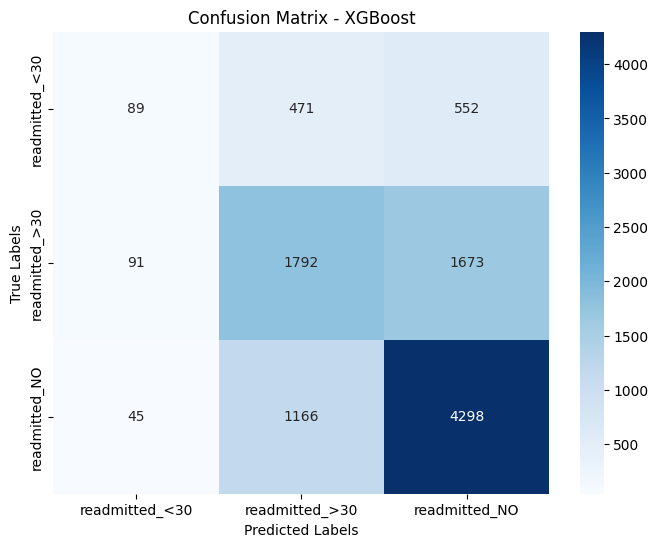

In [50]:
# Make predictions
y_pred = xgb_model.predict(X_test_)

print("Classification Report:\n")
print(classification_report(y_test_, y_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"], yticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

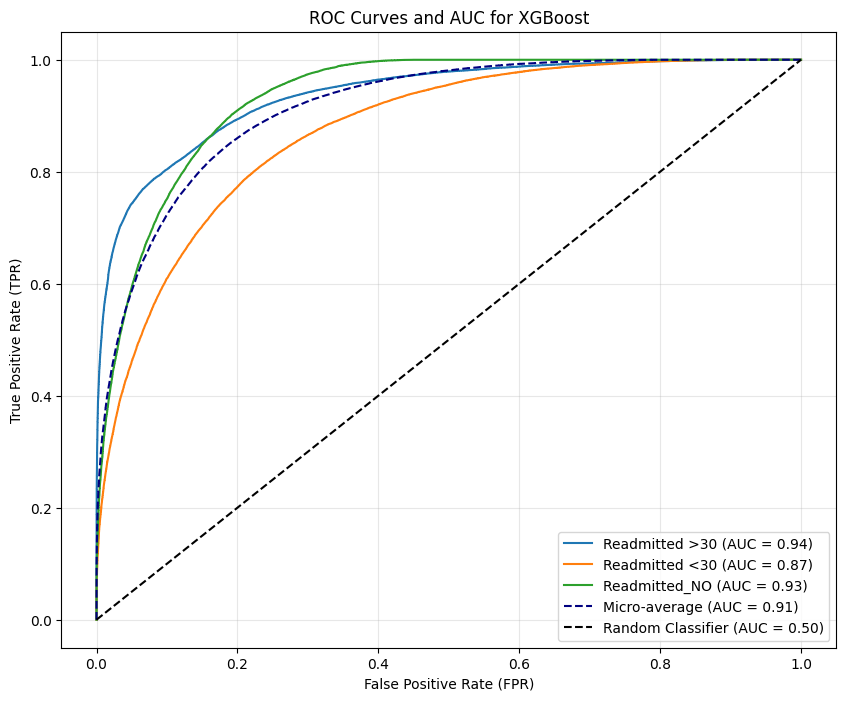

In [51]:
# Binarize the target labels
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Get probability predictions
y_pred_proba = xgb_model.predict_proba(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for XGBoost")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

---
## 5. Support Vector Machine

Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.17      0.54      0.26      1112
readmitted_>30       0.52      0.07      0.12      3556
 readmitted_NO       0.64      0.72      0.68      5509

      accuracy                           0.47     10177
     macro avg       0.44      0.44      0.35     10177
  weighted avg       0.55      0.47      0.44     10177



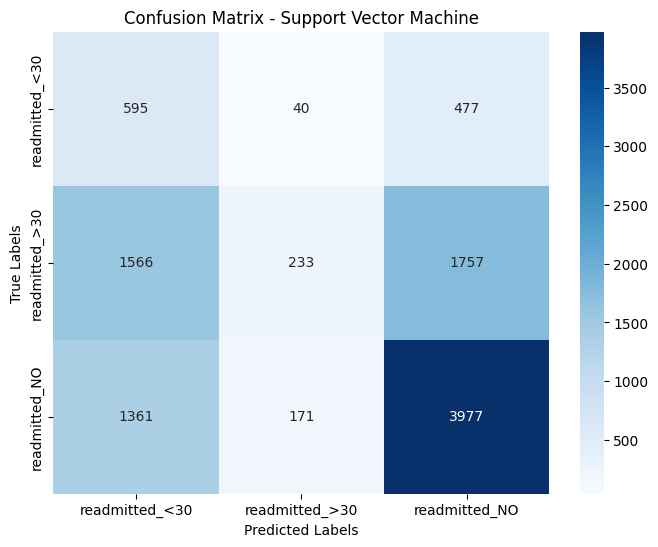

In [52]:
# Make predictions
y_pred = svm_model.predict(X_test_)

print("Classification Report:\n")
print(classification_report(y_test_, y_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"], yticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"])
plt.title("Confusion Matrix - Support Vector Machine")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

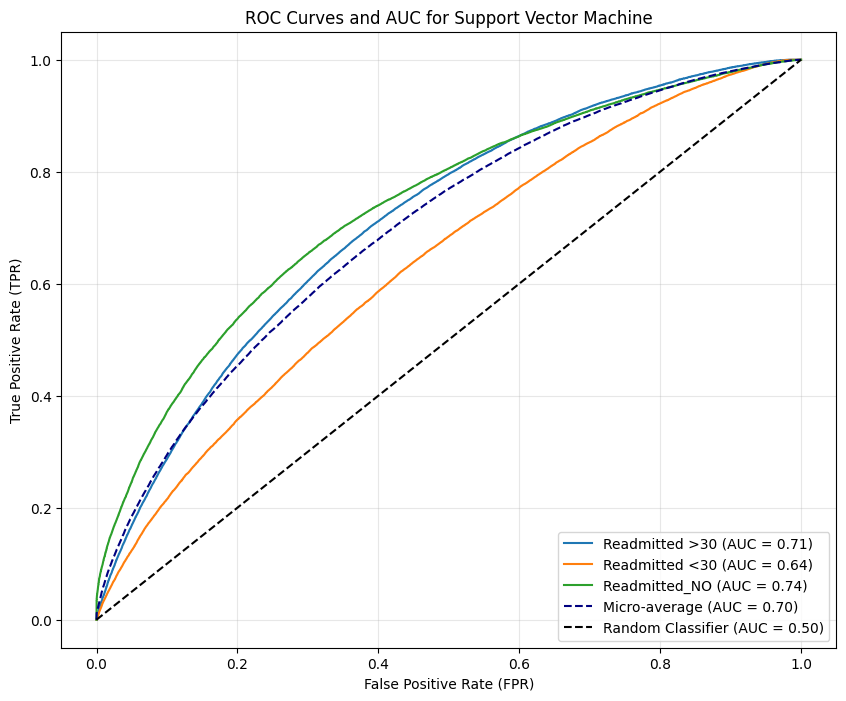

In [53]:
# Binarize the target labels
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Calibrate the model so that we could get probability predictions
calibrated_svm = CalibratedClassifierCV(svm_model, cv=5)
calibrated_svm.fit(X_train, y_train)

# Get probability predictions
y_pred_proba = calibrated_svm.predict_proba(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for Support Vector Machine")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

---
## 6. Random forest

Classification Report:

                precision    recall  f1-score   support

readmitted_<30       0.22      0.23      0.23      1112
readmitted_>30       0.50      0.36      0.42      3556
 readmitted_NO       0.65      0.75      0.70      5509

      accuracy                           0.56     10177
     macro avg       0.46      0.45      0.45     10177
  weighted avg       0.55      0.56      0.55     10177



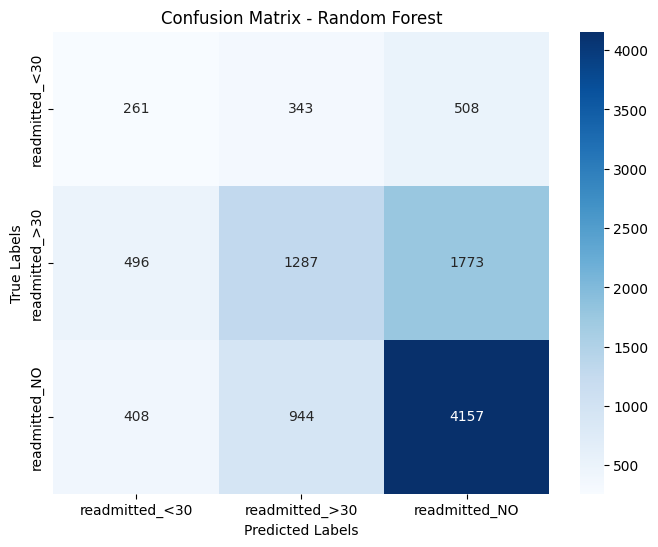

In [54]:
# Make predictions
y_pred = rf_model.predict(X_test_)

print("Classification Report:\n")
print(classification_report(y_test_, y_pred, target_names=["readmitted_<30", "readmitted_>30", "readmitted_NO"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"], yticklabels=["readmitted_<30", "readmitted_>30", "readmitted_NO"])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

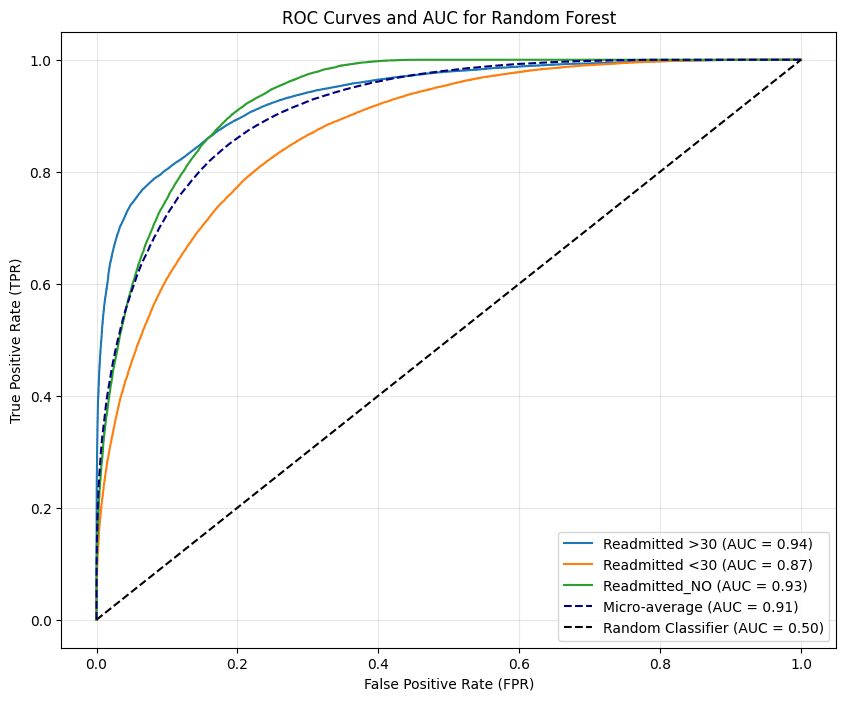

In [55]:
# Binarize the target labels
class_names = ['Readmitted >30', 'Readmitted <30', 'Readmitted_NO']
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2])
n_classes = y_train_binarized.shape[1]

# Get probability predictions
y_pred_proba = xgb_model.predict_proba(X_train)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average (AUC = {roc_auc['micro']:.2f})", linestyle='--', color='navy')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")

# Formatting the plot
plt.title("ROC Curves and AUC for Random Forest")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()